In [161]:
import psycopg2
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from seaborn import heatmap

# CV
from sklearn.model_selection import GridSearchCV

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [2]:
conn = psycopg2.connect(
    database='riot',
    user='admin',
    password='admin',
    host='db',
    port='5432'
)

engine = create_engine('postgresql+psycopg2://', creator=lambda: conn)

In [22]:
sql = '''SELECT * FROM input_dataset;'''
data = pd.read_sql(
    sql=sql,
    con=engine
).dropna()

data.shape

(13146, 132)

In [24]:
# Split into testing and training
X = data.values[:, 1:-1]
y = data.values[:, -1].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [25]:
# Scale to be 0 1
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [57]:
# PCA 
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# explain variance by first 2 components
print(np.sum(pca.explained_variance_ratio_[:2]))

# explained variance by first 10
print(np.sum(pca.explained_variance_ratio_[:10]))

#explained variance by first 25
print(np.sum(pca.explained_variance_ratio_[:25]))

0.11529448500264114
0.37372249008799496
0.6102497277884719


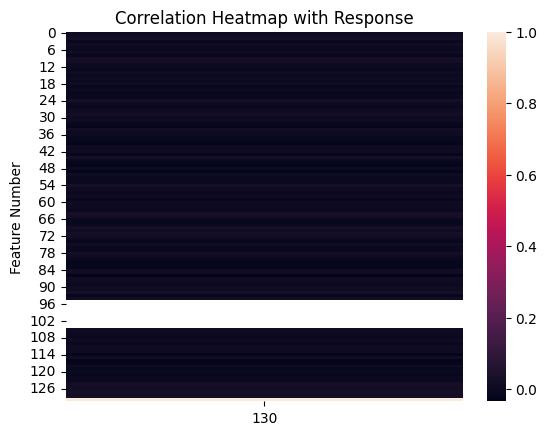

In [179]:
heatmap(
    pd.DataFrame(
        pd.DataFrame(
            np.concatenate(
                [X_train_scaled,y_train.reshape(y_train.shape[0], 1)], axis=1
            )
        ).corr().iloc[:, -1]
    )
)

plt.title('Correlation Heatmap with Response')
plt.ylabel('Feature Number')
plt.show()

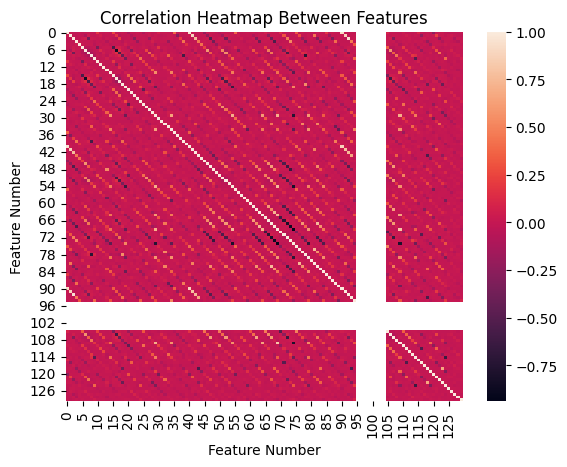

In [180]:
heatmap(pd.DataFrame(X_train_scaled).corr())
plt.title('Correlation Heatmap Between Features')
plt.ylabel('Feature Number')
plt.xlabel('Feature Number')
plt.show()

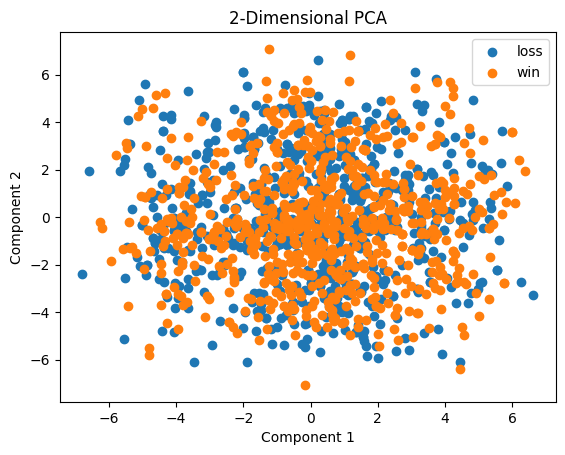

In [58]:
idx = np.random.choice(range(X_train_pca.shape[0]), 1500)
X_train_pca_smp = X_train_pca[idx, :]
y_train_smp = y_train[idx]


loss = np.where(y_train_smp == 0)
win = np.where(y_train_smp == 1)


plt.scatter(X_train_pca_smp[loss, 0], X_train_pca_smp[loss, 1], label='loss')
plt.scatter(X_train_pca_smp[win, 0], X_train_pca_smp[win, 1], label='win')
plt.title('2-Dimensional PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [74]:
# random forest
results = []
for k in [25, 50, 100, 130]:
    if k == 130:
        X_selected = X_train_scaled
    else:
        feature_selector = SelectKBest(mutual_info_classif, k=k)
        X_selected = feature_selector.fit_transform(X_train_scaled, y_train)
    params = {
        'n_estimators': [50, 100, 250, 500],
        'max_features': ['sqrt', 'log2', None]
    }
    rf = RandomForestClassifier(random_state=44)
    clf = GridSearchCV(rf, params, n_jobs=-1, verbose=3)
    clf.fit(X_selected, y_train)

    results.append(clf.cv_results_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=sqrt, n_estimators=100;, score=0.506 total time=   2.1s
[CV 4/5] END max_features=sqrt, n_estimators=250;, score=0.504 total time=   5.3s
[CV 4/5] END max_features=log2, n_estimators=50;, score=0.509 total time=   0.9s
[CV 2/5] END max_features=log2, n_estimators=100;, score=0.494 total time=   1.6s
[CV 5/5] END max_features=log2, n_estimators=100;, score=0.510 total time=   1.8s
[CV 2/5] END max_features=log2, n_estimators=250;, score=0.494 total time=   4.4s
[CV 3/5] END max_features=log2, n_estimators=500;, score=0.515 total time=   8.6s
[CV 2/5] END max_features=None, n_estimators=250;, score=0.512 total time=  18.9s
[CV 4/5] END max_features=None, n_estimators=500;, score=0.510 total time=  28.0s
[CV 2/5] END max_fe

In [105]:
feature_sets = [25, 50, 100, 130]
rf_scores = np.array([k['mean_test_score'] for k in results]).reshape(48)
params = []
for i, k in enumerate(results):
    n_features = feature_sets[i]
    # k['params']['n_features'] = n_features
    for d in k['params']:
        d['n_features'] = n_features
    params.append(k['params'])
params = np.array(params).reshape(48)

idx = np.argmax(rf_scores)
params[idx]

{'max_features': None, 'n_estimators': 500, 'n_features': 100}

In [113]:
# knn
knn_results = []
for k in [25, 50, 100, 130]:
    if k == 130:
        X_selected = X_train_scaled
    else:
        feature_selector = SelectKBest(mutual_info_classif, k=k)
        X_selected = feature_selector.fit_transform(X_train_scaled, y_train)
    params = {
        'n_neighbors': [5, 10, 25, 100],
    }
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, params, verbose=2)
    clf.fit(X_selected, y_train)

    knn_results.append(clf.cv_results_)

feature_sets = [25, 50, 100, 130]
knn_scores = np.array([k['mean_test_score'] for k in knn_results]).reshape(16)
params = []
for i, k in enumerate(knn_results):
    n_features = feature_sets[i]
    for d in k['params']:
        d['n_features'] = n_features
    params.append(k['params'])
params = np.array(params).reshape(16)

idx = np.argmax(knn_scores)
params[idx]

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END .....................................n_neighbors=10; total time=   0.0s
[CV] END .....................................n_neighbors=10; total time=   0.0s
[CV] END .....................................n_neighbors=10; total time=   0.0s
[CV] END .....................................n_neighbors=10; total time=   0.0s
[CV] END .....................................n_neighbors=10; total time=   0.0s
[CV] END .....................................n_neighbors=25; total time=   0.0s
[CV] END .....................................n_n

{'n_neighbors': 100, 'n_features': 100}

In [114]:
max(knn_scores)

0.5119827459956716

In [117]:
# svm
svm_results = []
for k in [25, 50, 100, 130]:
    if k == 130:
        X_selected = X_train_scaled
    else:
        feature_selector = SelectKBest(mutual_info_classif, k=k)
        X_selected = feature_selector.fit_transform(X_train_scaled, y_train)
    params = {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.001, 0.01, 0.1, 1, 10]
    }
    svc = SVC()
    clf = GridSearchCV(svc, params, verbose=2)
    clf.fit(X_selected, y_train)

    svm_results.append(clf.cv_results_)

feature_sets = [25, 50, 100, 130]
svm_scores = np.array([k['mean_test_score'] for k in svm_results]).reshape(60)
params = []
for i, k in enumerate(svm_results):
    n_features = feature_sets[i]
    for d in k['params']:
        d['n_features'] = n_features
    params.append(k['params'])
params = np.array(params).reshape(60)

idx = np.argmax(svm_scores)
params[idx]

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .............................C=0.001, kernel=linear; total time=   1.3s
[CV] END .............................C=0.001, kernel=linear; total time=   1.2s
[CV] END .............................C=0.001, kernel=linear; total time=   1.2s
[CV] END .............................C=0.001, kernel=linear; total time=   1.2s
[CV] END .............................C=0.001, kernel=linear; total time=   1.2s
[CV] END ...............................C=0.001, kernel=poly; total time=   1.3s
[CV] END ...............................C=0.001, kernel=poly; total time=   1.3s
[CV] END ...............................C=0.001, kernel=poly; total time=   1.3s
[CV] END ...............................C=0.001, kernel=poly; total time=   1.3s
[CV] END ...............................C=0.001, kernel=poly; total time=   1.3s
[CV] END ................................C=0.001, kernel=rbf; total time=   2.0s
[CV] END ................................C=0.001

{'C': 0.001, 'kernel': 'linear', 'n_features': 100}

In [118]:
max(svm_scores)

0.5290042832166252

In [123]:
# logit
logit_results = []
for k in [25, 50, 100, 130]:
    if k == 130:
        X_selected = X_train_scaled
    else:
        feature_selector = SelectKBest(mutual_info_classif, k=k)
        X_selected = feature_selector.fit_transform(X_train_scaled, y_train)
    params = {
        'penalty': [None]
    }
    logit = LogisticRegression()
    clf = GridSearchCV(logit, params, verbose=2)
    clf.fit(X_selected, y_train)

    logit_results.append(clf.cv_results_)

feature_sets = [25, 50, 100, 130]
logit_scores = np.array([k['mean_test_score'] for k in logit_results]).reshape(4)
params = []
for i, k in enumerate(logit_results):
    n_features = feature_sets[i]
    for d in k['params']:
        d['n_features'] = n_features
    params.append(k['params'])
params = np.array(params).reshape(4)

idx = np.argmax(logit_scores)
params[idx]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .......................................penalty=None; total time=   0.0s
[CV] END .......................................penalty=None; total time=   0.0s
[CV] END .......................................penalty=None; total time=   0.0s
[CV] END .......................................penalty=None; total time=   0.0s
[CV] END .......................................penalty=None; total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .......................................penalty=None; total time=   0.1s
[CV] END .......................................penalty=None; total time=   0.1s
[CV] END .......................................penalty=None; total time=   0.1s
[CV] END .......................................penalty=None; total time=   0.0s
[CV] END .......................................penalty=None; total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....

{'penalty': None, 'n_features': 100}

In [124]:
params[idx]

{'penalty': None, 'n_features': 100}

In [126]:
np.max(logit_scores)

0.5255808287635444

In [127]:
# final rf
feature_selector = SelectKBest(mutual_info_classif, k=100)
X_selected = feature_selector.fit_transform(X_train_scaled, y_train)
rf = RandomForestClassifier(
    max_features=None,
    n_estimators=500,
    random_state=44
)
rf.fit(X_selected, y_train)

RandomForestClassifier(max_features=None, n_estimators=500, random_state=44)

In [128]:
# final knn
feature_selector = SelectKBest(mutual_info_classif, k=100)
X_selected = feature_selector.fit_transform(X_train_scaled, y_train)
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_selected, y_train)

KNeighborsClassifier(n_neighbors=100)

In [129]:
# final svm
feature_selector = SelectKBest(mutual_info_classif, k=100)
X_selected = feature_selector.fit_transform(X_train_scaled, y_train)
svm = SVC(
    C=0.001,
    kernel='linear',
    random_state=44
)
svm.fit(X_selected, y_train)

SVC(C=0.001, kernel='linear', random_state=44)

In [130]:
# final logit
feature_selector = SelectKBest(mutual_info_classif, k=100)
X_selected = feature_selector.fit_transform(X_train_scaled, y_train)
logit = LogisticRegression()
logit.fit(X_selected, y_train)

LogisticRegression()

In [140]:
rf_best_scores = np.max(np.array([k['mean_test_score'] for k in results]), axis=1)
knn_best_scores = np.max(np.array([k['mean_test_score'] for k in knn_results]), axis=1)
svm_best_scores = np.max(np.array([k['mean_test_score'] for k in svm_results]), axis=1)
logit_best_scores = np.max(np.array([k['mean_test_score'] for k in logit_results]), axis=1)

In [144]:
X_test_selected = feature_selector.transform(X_test_scaled)

In [150]:
print('test accuracy: ', rf.score(X_test_selected, y_test))
rf_pred = rf.predict(X_test_selected)
print('f1 score: ', f1_score(y_test, rf_pred))
print('precision score: ', precision_score(y_test, rf_pred))
print('recall score: ', recall_score(y_test, rf_pred))
print(confusion_matrix(y_test, rf_pred))

test accuracy:  0.5250950570342205
f1 score:  0.5175743530320587
precision score:  0.5275590551181102
recall score:  0.5079605761940864
[[711 600]
 [649 670]]


In [158]:
print('test accuracy: ', knn.score(X_test_selected, y_test))
knn_pred = knn.predict(X_test_selected)
print('f1 score: ', f1_score(y_test, knn_pred))
print('precision score: ', precision_score(y_test, knn_pred))
print('recall score: ', recall_score(y_test, knn_pred))
print(confusion_matrix(y_test, knn_pred))

test accuracy:  0.5022813688212928
f1 score:  0.5795053003533569
precision score:  0.5027870680044593
recall score:  0.6838514025777104
[[419 892]
 [417 902]]


In [159]:
print('test accuracy: ', svm.score(X_test_selected, y_test))
svm_pred = svm.predict(X_test_selected)
print('f1 score: ', f1_score(y_test, svm_pred))
print('precision score: ', precision_score(y_test, svm_pred))
print('recall score: ', recall_score(y_test, svm_pred))
print(confusion_matrix(y_test, svm_pred))

test accuracy:  0.5201520912547528
f1 score:  0.5043205027494108
precision score:  0.5232273838630807
recall score:  0.48673237300985595
[[726 585]
 [677 642]]


In [160]:
print('test accuracy: ', logit.score(X_test_selected, y_test))
logit_pred = logit.predict(X_test_selected)
print('f1 score: ', f1_score(y_test, logit_pred))
print('precision score: ', precision_score(y_test, logit_pred))
print('recall score: ', recall_score(y_test, logit_pred))
print(confusion_matrix(y_test, logit_pred))

test accuracy:  0.5307984790874525
f1 score:  0.5275650842266463
precision score:  0.5328692962103635
recall score:  0.5223654283548143
[[707 604]
 [630 689]]


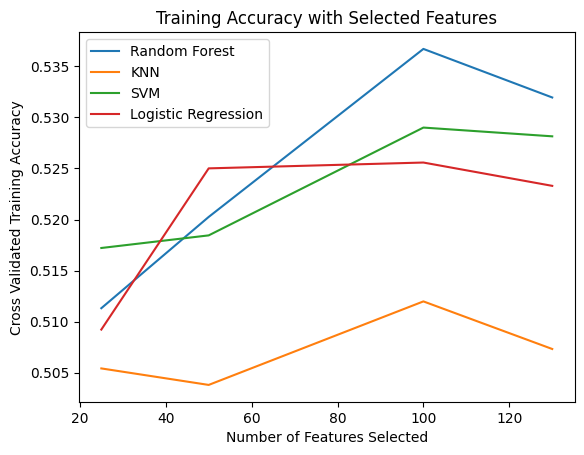

In [157]:
plt.plot(feature_sets, rf_best_scores, label='Random Forest')
plt.plot(feature_sets, knn_best_scores, label='KNN')
plt.plot(feature_sets, svm_best_scores, label='SVM')
plt.plot(feature_sets, logit_best_scores, label='Logistic Regression')
plt.title('Training Accuracy with Selected Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validated Training Accuracy')
plt.legend()